## Test Point Cloud Register


In [3]:
# import torch
# import numpy as np
# import open3d as o3d
# from pytorch3d.loss import chamfer_distance
# from pytorch3d.transforms import so3_exponential_map
# import matplotlib.pyplot as plt

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def load_point_cloud(file_path):
#     pcd = o3d.io.read_point_cloud(file_path)
#     return torch.tensor(np.asarray(pcd.points), dtype=torch.float32).to(device)

# def visualize_step(source, target, transformed, step):
#     source_pcd = o3d.geometry.PointCloud()
#     source_pcd.points = o3d.utility.Vector3dVector(source.cpu().numpy())
#     source_pcd.paint_uniform_color([1, 0, 0])  

#     target_pcd = o3d.geometry.PointCloud()
#     target_pcd.points = o3d.utility.Vector3dVector(target.cpu().numpy())
#     target_pcd.paint_uniform_color([0, 1, 0])  

#     transformed_pcd = o3d.geometry.PointCloud()
#     transformed_pcd.points = o3d.utility.Vector3dVector(transformed.cpu().detach().numpy())
#     transformed_pcd.paint_uniform_color([0, 0, 1])  

#     print(f"Step {step}: Visualizing...")
#     o3d.visualization.draw_geometries([source_pcd, target_pcd, transformed_pcd])

# source_pcd = load_point_cloud("render_geometry.ply")  
# target_pcd = load_point_cloud("smal_target_cow_alph5.ply")

# rot_vector = torch.zeros(3, requires_grad=True, device=device)  
# translation = torch.zeros(3, requires_grad=True, device=device) 

# optimizer = torch.optim.Adam([rot_vector, translation], lr=0.01)

# num_iterations = 20
# for i in range(num_iterations):
#     optimizer.zero_grad()
    
    
#     R = so3_exponential_map(rot_vector.unsqueeze(0)).squeeze(0)  
    
#     transformed_pcd = (source_pcd @ R.T) + translation  
    
#     loss, _ = chamfer_distance(transformed_pcd.unsqueeze(0), target_pcd.unsqueeze(0))
    
#     loss.backward()
#     optimizer.step()
    
#     print(f"Iteration {i}: Loss = {loss.item():.6f}")

#     if i % 2 == 0:
#         visualize_step(source_pcd, target_pcd, transformed_pcd, i)

# visualize_step(source_pcd, target_pcd, transformed_pcd, "Final")


Step 0: Loss = 0.718678 (Visualizing...)
Step 1: Loss = 0.691595 (Visualizing...)
Step 2: Loss = 0.665459 (Visualizing...)
Step 3: Loss = 0.640291 (Visualizing...)
Step 4: Loss = 0.616178 (Visualizing...)
Step 5: Loss = 0.593045 (Visualizing...)
Step 6: Loss = 0.570786 (Visualizing...)
Step 7: Loss = 0.549479 (Visualizing...)
Step 8: Loss = 0.529125 (Visualizing...)
Step 9: Loss = 0.509761 (Visualizing...)
Step 10: Loss = 0.491320 (Visualizing...)
Step 11: Loss = 0.473765 (Visualizing...)
Step 12: Loss = 0.457067 (Visualizing...)
Step 13: Loss = 0.441212 (Visualizing...)
Step 14: Loss = 0.426169 (Visualizing...)
Step 15: Loss = 0.411940 (Visualizing...)
Step 16: Loss = 0.398510 (Visualizing...)
Step 17: Loss = 0.385776 (Visualizing...)
Step 18: Loss = 0.373739 (Visualizing...)
Step 19: Loss = 0.362355 (Visualizing...)
Step 20: Loss = 0.351483 (Visualizing...)
Step 21: Loss = 0.341069 (Visualizing...)
Step 22: Loss = 0.331140 (Visualizing...)
Step 23: Loss = 0.321711 (Visualizing...)
St

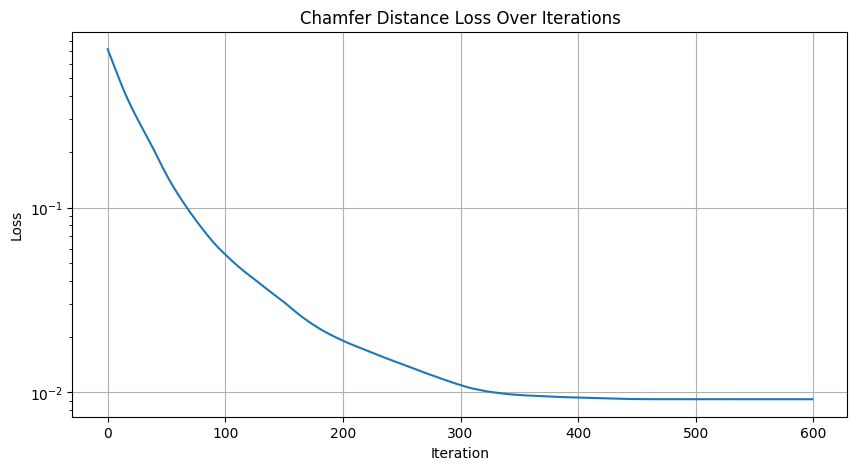

In [8]:
import torch
import numpy as np
import open3d as o3d
import time
from pytorch3d.loss import chamfer_distance
from pytorch3d.transforms import so3_exponential_map
import matplotlib.pyplot as plt
import copy
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    return torch.tensor(np.asarray(pcd.points), dtype=torch.float32).to(device)

class RegistrationVisualizer:
    """Class for continuous visualization of point cloud registration"""
    def __init__(self, source, target):
        # Create a window and add geometries
        self.vis = o3d.visualization.Visualizer()
        self.vis.create_window(window_name="Point Cloud Registration")
        ctr = self.vis.get_view_control()
        params = ctr.convert_to_pinhole_camera_parameters()
       
        
        # Create point clouds
        self.source_pcd = o3d.geometry.PointCloud()
        self.source_pcd.points = o3d.utility.Vector3dVector(source.cpu().numpy())
        self.source_pcd.paint_uniform_color([1, 0.2, 0.2])  # Red for source
        
        self.target_pcd = o3d.geometry.PointCloud()
        self.target_pcd.points = o3d.utility.Vector3dVector(target.cpu().numpy())
        self.target_pcd.paint_uniform_color([0, 1, 0])  # Green for target
        
        self.transformed_pcd = o3d.geometry.PointCloud()
        self.transformed_pcd.points = o3d.utility.Vector3dVector(source.cpu().numpy())
        self.transformed_pcd.paint_uniform_color([1, 1, 1])  # Blue for transformed
        
        # Add to visualizer
        self.vis.add_geometry(self.source_pcd)
        self.vis.add_geometry(self.target_pcd)
        self.vis.add_geometry(self.transformed_pcd)
        
       

        # Set visualization options
        opt = self.vis.get_render_option()
        opt.background_color = np.array([0.1, 0.1, 0.1])
        opt.point_size = 8.0
        opt.point_show_normal = False  # Make sure this is false to get circular points

        # Set initial view
        self.vis.reset_view_point(True)
        self.vis.update_renderer()
        
        # Initialize loss history
        self.loss_history = []
    
    def update(self, transformed_points, iteration, loss):
        """Update visualization with new transformed points"""
        self.loss_history.append(loss)
        
        # Update transformed point cloud
        self.transformed_pcd.points = o3d.utility.Vector3dVector(transformed_points.cpu().detach().numpy())
        self.vis.update_geometry(self.transformed_pcd)
        
        # Print progress instead of updating window title
        print(f"Step {iteration}: Loss = {loss:.6f} (Visualizing...)")
        
         # Make sure point size stays small
        self.vis.get_render_option().point_size = 2.0
        # Update view and render
        self.vis.poll_events()
        self.vis.update_renderer()
        time.sleep(0.05)  # Small delay to make visualization smoother
    
    def plot_loss_history(self):
        """Plot the loss history"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title('Chamfer Distance Loss Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.yscale('log')  # Log scale often helps visualize convergence
        plt.grid(True)
        plt.show()
    
    def close(self):
        """Close the visualizer"""
        self.vis.destroy_window()

# Load point clouds
theta = np.deg2rad(180)
Rx = torch.tensor([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta),  np.cos(theta)]
], dtype=source_pcd.dtype, device=source_pcd.device)


source_pcd = load_point_cloud("render_500.ply")
source_pcd = source_pcd @ Rx.T
target_pcd = load_point_cloud("template_500.ply")
target_pcd = target_pcd @ Rx.T
# Initialize the visualizer
visualizer = RegistrationVisualizer(source_pcd, target_pcd)

# Setup optimization
rot_vector = torch.zeros(3, requires_grad=True, device=device)  
translation = torch.zeros(3, requires_grad=True, device=device) 
optimizer = torch.optim.Adam([rot_vector, translation], lr=0.01)

# Run the optimization with continuous visualization
num_iterations = 600  # Same as your original code, adjust as needed

try:
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Calculate rotation matrix from axis-angle
        R = so3_exponential_map(rot_vector.unsqueeze(0)).squeeze(0)  
        
        # Apply transformation
        transformed_pcd = (source_pcd @ R.T) + translation  
        
        # Calculate loss
        loss, _ = chamfer_distance(transformed_pcd.unsqueeze(0), target_pcd.unsqueeze(0))
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Update visualization
        visualizer.update(transformed_pcd, i, loss.item())
        
except KeyboardInterrupt:
    print("Optimization interrupted by user")
finally:
    print("\nOptimization completed")
    print(f"Final loss: {loss.item():.6f}")

# Plot loss history
visualizer.plot_loss_history()

# Close the visualizer when done
visualizer.close()